In [1]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_predict
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import os
import sys
from scipy.stats import linregress

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Add project root to path (for Jupyter notebooks)
# Get the current directory and navigate to project root
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)

from src.config import Config
import src.eda as eda
import src.present_value as present_value

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


c:\Users\forer\anaconda3\envs\practicum\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
## FROM DATABASE
pv = present_value.PresentValue()
anual_increment = pv.fetch_incremento_from_database()

fase = "III"
preproccesing = eda.EDA()
df_raw = preproccesing.assemble_projects_from_database(fase)
df_vp = preproccesing.create_dataset(pv.present_value_costs, fase=fase)

c:\Code\Road-Project-Prediction\src\eda.py:292: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [6]:
df = df_vp.loc[:, 'CÓDIGO':'ALCANCE'].join(df_vp.loc[:, ['4 - SUELOS']])
df_grouped = df.groupby('CÓDIGO').agg({
    'ALCANCE': 'first',
    'PUENTES VEHICULARES UND': 'sum',
    'PUENTES VEHICULARES M2': 'sum',
    'PUENTES PEATONALES UND': 'sum',
    '4 - SUELOS': 'sum'
}).reset_index()
puentes_cols = ['PUENTES VEHICULARES UND', 'PUENTES VEHICULARES M2', 'PUENTES PEATONALES UND']
df_filtered = df_grouped[(df_grouped[puentes_cols].sum(axis=1) > 0) & (df_grouped['4 - SUELOS'] > 0)]
df_filtered = df_filtered[df_filtered['CÓDIGO']!='0654801']
df_filtered

,CÓDIGO,ALCANCE,PUENTES VEHICULARES UND,PUENTES VEHICULARES M2,PUENTES PEATONALES UND,4 - SUELOS
0,0001,Segunda calzada,11,4856,14,1.878437e+08
3,0266702,Mejoramiento,0,0,1,1.326106e+07
5,0300605,Segunda calzada,13,16654,0,1.308015e+08
7,0347801,Rehabilitación,26,51069,0,8.669950e+08
9,0552903,Mejoramiento,6,3837,0,6.696069e+07
10,0581301,Mejoramiento,2,38,0,4.285348e+07
12,6935,Segunda calzada,4,6292,1,1.029912e+08


In [51]:
def remove_outliers(df, target: str, method='ensemble', contamination=0.1, voting_threshold=0.5):
    df_nonzero = df[df[target] != 0].copy()
    
    if len(df_nonzero) < 10:
        return df_nonzero
    
    numerical_cols = df_nonzero.select_dtypes(include=[np.number]).columns.tolist()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_nonzero[numerical_cols])
    
    outlier_flags = {}
    
    if method in ['ensemble', 'isolation_forest', 'all_strict']:
        iso_forest = IsolationForest(contamination=contamination, random_state=42, n_estimators=200)
        iso_predictions = iso_forest.fit_predict(X_scaled)
        outlier_flags['isolation_forest'] = (iso_predictions == -1)
        
    if method in ['ensemble', 'lof', 'all_strict']:
        n_neighbors = min(20, len(df_nonzero) - 1)
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
        lof_predictions = lof.fit_predict(X_scaled)
        outlier_flags['lof'] = (lof_predictions == -1)
    
    if method in ['ensemble', 'robust_statistical', 'all_strict']:
        target_values = df_nonzero[target].values
        median = np.median(target_values)
        mad = np.median(np.abs(target_values - median))
        if mad != 0:
            modified_z_scores = 0.6745 * (target_values - median) / mad
            outlier_flags['robust_statistical'] = np.abs(modified_z_scores) > 3.5
        else:
            outlier_flags['robust_statistical'] = np.zeros(len(df_nonzero), dtype=bool)
    
    if method in ['ensemble', 'all_strict']:
        target_scaled = scaler.fit_transform(df_nonzero[[target]])
        outlier_flags['z_score'] = np.abs(target_scaled.flatten()) > 3
    
    if method == 'ensemble':
        outlier_matrix = np.column_stack(list(outlier_flags.values()))
        votes = outlier_matrix.sum(axis=1)
        is_outlier = votes >= (len(outlier_flags) * voting_threshold)
    elif method == 'all_strict':
        outlier_matrix = np.column_stack(list(outlier_flags.values()))
        is_outlier = outlier_matrix.all(axis=1)
    else:
        is_outlier = outlier_flags[method]
    
    df_clean = df_nonzero[~is_outlier].copy()
    
    n_outliers = is_outlier.sum()
    pct_removed = (n_outliers / len(df_nonzero)) * 100
    print(f"Removed {n_outliers}/{len(df_nonzero)} outliers ({pct_removed:.1f}%)")
    
    return df_clean

df_clean = remove_outliers(df_filtered, '4 - SUELOS', contamination=0.1)


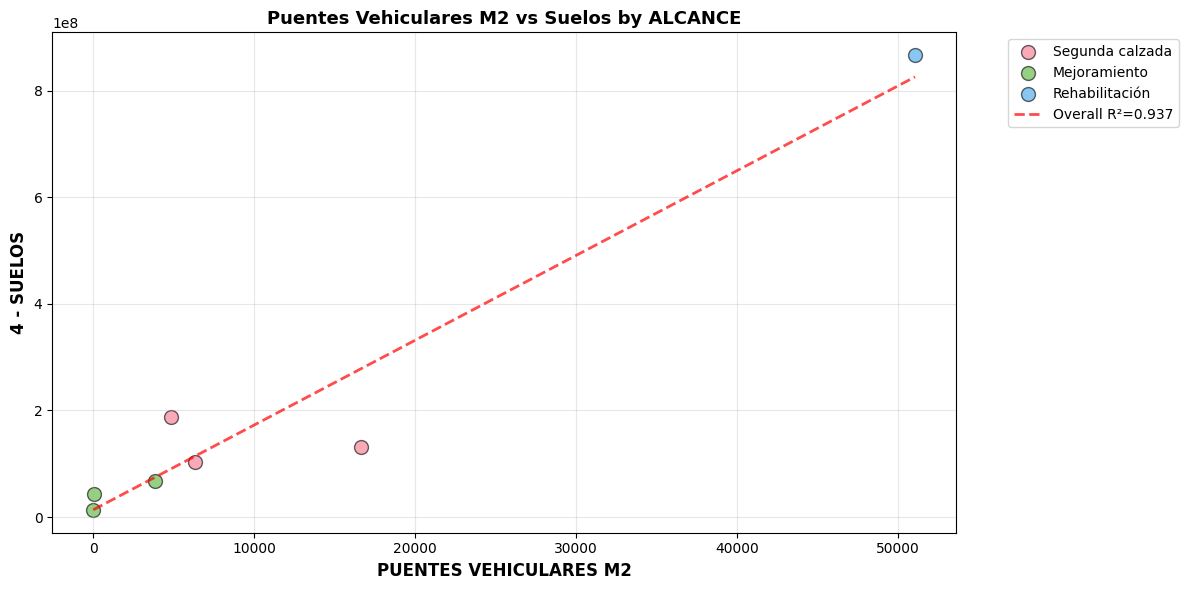

In [45]:
# Scatter plot with ALCANCE as hue
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique ALCANCE values and assign colors
alcances = df_filtered['ALCANCE'].unique()
color_palette = sns.color_palette("husl", len(alcances))
color_map = dict(zip(alcances, color_palette))

# Plot each ALCANCE category separately
for alcance in alcances:
    mask = df_filtered['ALCANCE'] == alcance
    df_alcance = df_filtered[mask]
    
    ax.scatter(df_alcance['PUENTES VEHICULARES M2'], 
               df_alcance['4 - SUELOS'],
               alpha=0.6, s=100, 
               color=color_map[alcance],
               edgecolors='black', 
               linewidth=1,
               label=alcance)

# Overall regression line
slope, intercept, r_value, p_value, _ = linregress(df_filtered['PUENTES VEHICULARES M2'], 
                                                     df_filtered['4 - SUELOS'])
x_line = np.linspace(df_filtered['PUENTES VEHICULARES M2'].min(), 
                     df_filtered['PUENTES VEHICULARES M2'].max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.7, label=f'Overall R²={r_value**2:.3f}')

# Labels and title
ax.set_xlabel('PUENTES VEHICULARES M2', fontsize=12, fontweight='bold')
ax.set_ylabel('4 - SUELOS', fontsize=12, fontweight='bold')
ax.set_title('Puentes Vehiculares M2 vs Suelos by ALCANCE', fontsize=13, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [52]:
# Function to calculate comprehensive metrics
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculate and return comprehensive regression metrics"""
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Additional metrics
    median_ae = np.median(np.abs(y_true - y_pred))
    max_error = np.max(np.abs(y_true - y_pred))
    
    return {
        'Model': model_name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'Median AE': median_ae,
        'Max Error': max_error
    }


## 2. Log Transformation of Target (y)


In [57]:
# LOG(y) Transformation
print("=" * 70)
print("Log(y) Transformation")
print("=" * 70)

# Prepare data for advanced analysis
X_m2 = df_clean[['PUENTES VEHICULARES M2']].values.flatten()
y_suelos = df_clean['4 - SUELOS'].values

# Remove zeros to allow log transformation
mask_nonzero = (X_m2 > 0) & (y_suelos > 0)
X_m2_clean = X_m2[mask_nonzero]
y_clean = y_suelos[mask_nonzero]


loo = LeaveOneOut()
results = []

X_log_y = X_m2_clean.reshape(-1, 1)
y_log = np.log(y_clean)

# Using TransformedTargetRegressor for proper inverse transformation
model_log_y = TransformedTargetRegressor(
    regressor=Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    func=np.log,
    inverse_func=np.exp
)

# Manual LOO to handle transformation properly
y_pred_log_y = np.zeros_like(y_clean)
for train_idx, test_idx in loo.split(X_log_y):
    X_train, X_test = X_log_y[train_idx], X_log_y[test_idx]
    y_train, y_test = y_clean[train_idx], y_clean[test_idx]
    
    model_log_y.fit(X_train, y_train)
    y_pred_log_y[test_idx] = model_log_y.predict(X_test)

metrics_log_y = calculate_metrics(y_clean, y_pred_log_y, "Log(y) Transform")
results.append(metrics_log_y)

print(f"R²:         {metrics_log_y['R²']:.4f}")
print(f"RMSE:       {metrics_log_y['RMSE']:.2f}")
print(f"MAPE:       {metrics_log_y['MAPE (%)']:.2f}%")
print()


Log(y) Transformation
R²:         0.9307
RMSE:       75610324.78
MAPE:       39.00%

